In [1]:
import numpy as np
import pandas as pd

import neurodsp
from neurodsp import shape
from scipy import stats
from collections import defaultdict

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

# Quantify rat movement

In [2]:
# Load raw data
lfp_raw = np.load('data/ca1.npy')
Fs_lfp = 1252
t_lfp = np.arange(0, len(lfp_raw)/Fs_lfp, 1/Fs_lfp)
f_theta = (4, 10)

# Apply broad bandpass filter
f_bandpass = (1, 25)
filter_seconds = (2, .5)
lfp = neurodsp.filter(lfp_raw, Fs_lfp, 'highpass', f_hi=f_bandpass[0],
                      N_seconds=filter_seconds[0],
                      remove_edge_artifacts=False)
lfp = neurodsp.filter(lfp, Fs_lfp, 'lowpass', f_lo=f_bandpass[1],
                      N_seconds=filter_seconds[1],
                      remove_edge_artifacts=False)

# Compute cycle-by-cycle features
osc_kwargs = {'amplitude_fraction_threshold':0,
              'amplitude_consistency_threshold':.6,
              'period_consistency_threshold':.75,
              'monotonicity_threshold':.8,
              'N_cycles_min':3}
df = shape.features_by_cycle(lfp, Fs_lfp, f_theta, center_extrema='T',
                             estimate_oscillating_periods=True,
                             estimate_oscillating_periods_kwargs=osc_kwargs)

# Load rat positions
pos_mat = np.load('data/ca1_position.npy')
x_nose_39, y_nose_39, x_body_39, y_body_39 = pos_mat.T
Fs_pos = 39.0625
t_pos = np.arange(0, len(x_nose_39) / Fs_pos, 1 / Fs_pos)

# Replace -1 with NaN
x_body_39[x_body_39 == -1] = np.nan
y_body_39[y_body_39 == -1] = np.nan

# Interpolate position
x_body = np.interp(t_lfp, t_pos, x_body_39)
y_body = np.interp(t_lfp, t_pos, y_body_39)

# Compute average x and y coordinates for each cycle
N_cycles = len(df)
x_by_cycle = np.zeros(N_cycles)
y_by_cycle = np.zeros(N_cycles)
for i, row in df.iterrows():
    samp_start = int(row['sample_trough'] + row['sample_last_peak'])
    samp_end = int(row['sample_trough'] + row['sample_next_peak'])
    x_by_cycle[i] = np.nanmean(x_body[samp_start:samp_end])
    y_by_cycle[i] = np.nanmean(y_body[samp_start:samp_end])

df['x_pos'] = x_by_cycle
df['y_pos'] = y_by_cycle

# Compute speed of rat for every cycle
speed_by_cycle = np.zeros(len(df))
for i, row in df.iterrows():
    dx = x_body[row['sample_next_peak']] - x_body[row['sample_last_peak']]
    dy = y_body[row['sample_next_peak']] - y_body[row['sample_last_peak']]
    dist = np.sqrt(dx ** 2 + dy ** 2)
    speed_by_cycle[i] = dist / row['period'] * Fs_lfp
df['speed'] = speed_by_cycle

/Users/scott/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/scott/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/scott/anaconda/lib/python3.6/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/Users/scott/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
/Users/scott/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice


# A-C. Example raw data

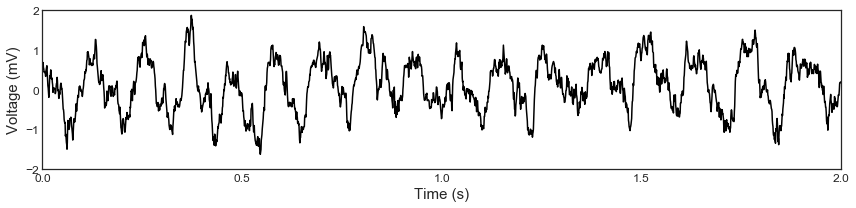

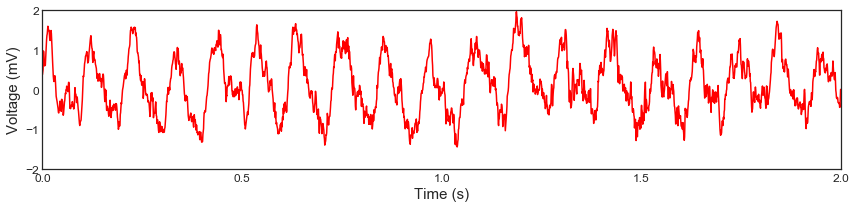

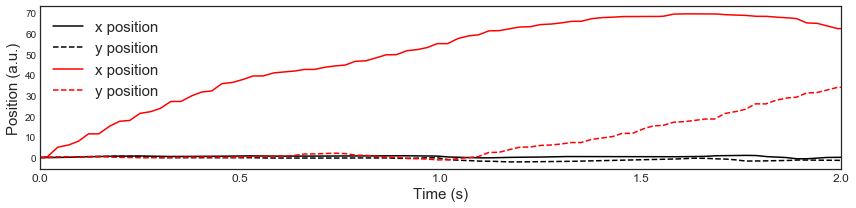

In [3]:
tlim1 = np.array([1108, 1110])
tidx1 = np.logical_and(t_lfp >= tlim1[0], t_lfp < tlim1[1])
plt.figure(figsize=(12,3))
plt.plot(t_lfp[tidx1] - tlim1[0], lfp_raw[tidx1]/1000, 'k')
plt.xlim(tlim1-tlim1[0])
plt.ylim(-2, 2)
plt.xlabel('Time (s)', size=15)
plt.ylabel('Voltage (mV)', size=15)
plt.yticks(np.arange(-2,3), size=12)
plt.xticks(np.arange(0,2.5,.5), size=12)
plt.tight_layout()
plt.savefig('figs/8A_slow_time_series.png')

tlim2 = np.array([1124, 1126])
tidx2 = np.logical_and(t_lfp >= tlim2[0], t_lfp < tlim2[1])
plt.figure(figsize=(12,3))
plt.plot(t_lfp[tidx2] - tlim2[0], lfp_raw[tidx2]/1000, 'r')
plt.xlim(tlim2-tlim2[0])
plt.ylim(-2, 2)
plt.xlabel('Time (s)', size=15)
plt.ylabel('Voltage (mV)', size=15)
plt.yticks(np.arange(-2,3), size=12)
plt.xticks(np.arange(0,2.5,.5), size=12)
plt.tight_layout()
plt.savefig('figs/8B_fast_time_series.png')

# Plot x and y speeds for both time series
plt.figure(figsize=(12,3))
plt.plot(t_lfp[tidx2] - tlim2[0], x_body[tidx1] - x_body[tidx1][0], 'k', label='x position')
plt.plot(t_lfp[tidx2] - tlim2[0], y_body[tidx1] - y_body[tidx1][0], 'k--', label='y position')
plt.plot(t_lfp[tidx2] - tlim2[0], -x_body[tidx2] + x_body[tidx2][0], 'r', label='x position')
plt.plot(t_lfp[tidx2] - tlim2[0], -y_body[tidx2] + y_body[tidx2][0], 'r--', label='y position')
plt.xlim(tlim2-tlim2[0])
plt.xlabel('Time (s)', size=15)
plt.ylabel('Position (a.u.)', size=15)
plt.xticks(np.arange(0,2.5,.5), size=12)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('figs/8C_position_time_series.png');

# D-G. Distributions of cycle features for running and not running

/Users/scott/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/scott/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


amp_mv MannwhitneyuResult(statistic=899832.0, pvalue=1.401941789275902e-08)
periods MannwhitneyuResult(statistic=653180.5, pvalue=4.1928014140583106e-63)
time_rdsym MannwhitneyuResult(statistic=819682.5, pvalue=2.0923758831106097e-20)
time_ptsym MannwhitneyuResult(statistic=755079.0, pvalue=4.7293996054829404e-34)


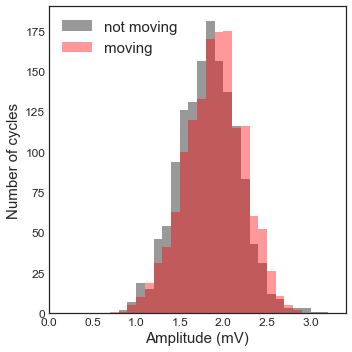

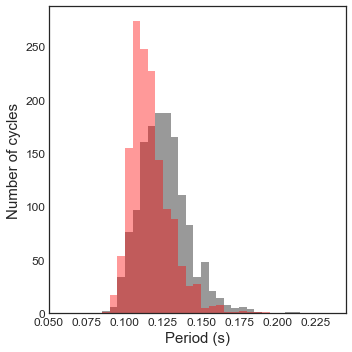

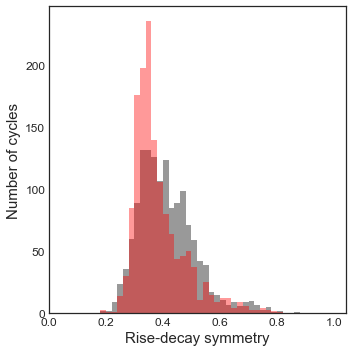

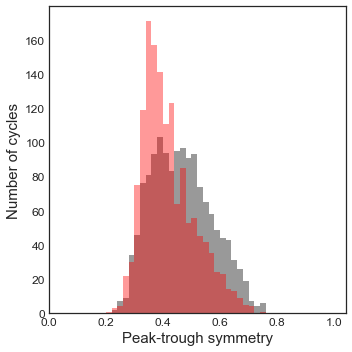

In [6]:
# Change amplitude and period units
df_cycles = df[df['is_cycle']]
df_cycles['periods'] = df_cycles['period'] / Fs_lfp
df_cycles['amp_mv'] = df_cycles['volt_amp'] / 1000

# Make distributions of features, comparing running condition
feat_names = {'amp_mv': 'Amplitude (mV)',
              'periods': 'Period (s)',
              'time_rdsym': 'Rise-decay symmetry',
              'time_ptsym': 'Peak-trough symmetry'}
feat_figletter = {'amp_mv': 'D', 'periods': 'E',
                  'time_rdsym': 'F', 'time_ptsym': 'G'}
feat_bins = {'amp_mv': np.arange(0, 3.5, .1),
             'periods': np.arange(.05, .25, .005),
             'time_rdsym': np.arange(0, 1.05, .02),
             'time_ptsym': np.arange(0, 1.05, .02)}

df_fast = df_cycles[df_cycles['speed'] >= df_cycles['speed'].quantile(.9)]
df_slow = df_cycles[df_cycles['speed'] <= df_cycles['speed'].quantile(.1)]

for feat, name in feat_names.items():
    plt.figure(figsize=(5,5))
    sns.distplot(df_slow[feat], bins=feat_bins[feat], 
                 color='k', kde=False, label='not moving')
    sns.distplot(df_fast[feat], bins=feat_bins[feat], 
                 color='r', kde=False, label='moving')
    plt.ylabel('Number of cycles', size=15)
    if feat == 'amp_mv':
        plt.legend(fontsize=15)
    plt.xlabel(name, size=15)
    plt.xlim((feat_bins[feat][0], feat_bins[feat][-1]))
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.tight_layout()
    plt.savefig('figs/8{:s}_{:s}_dist_fastslow.png'.format(feat_figletter[feat], feat))
    
    print(feat, stats.mannwhitneyu(df_slow[feat], df_fast[feat]))

# H-K. Correlations between speed and cycle features

amp_mv SpearmanrResult(correlation=0.05009382663889983, pvalue=masked_array(data = 2.063204769172399e-09,
             mask = False,
       fill_value = 1e+20)
)
periods SpearmanrResult(correlation=-0.15481681311044815, pvalue=masked_array(data = 2.148525189140033e-77,
             mask = False,
       fill_value = 1e+20)
)
time_rdsym SpearmanrResult(correlation=-0.054322667878247799, pvalue=masked_array(data = 8.065775132954538e-11,
             mask = False,
       fill_value = 1e+20)
)
time_ptsym SpearmanrResult(correlation=-0.11354273151721417, pvalue=masked_array(data = 3.099989177174827e-42,
             mask = False,
       fill_value = 1e+20)
)


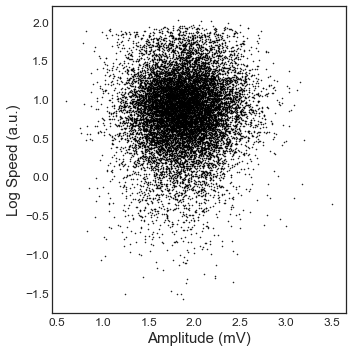

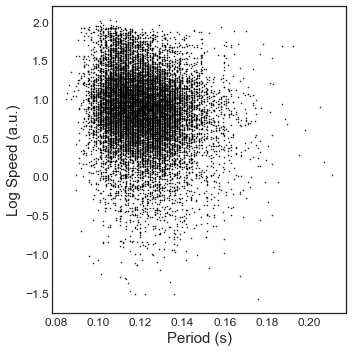

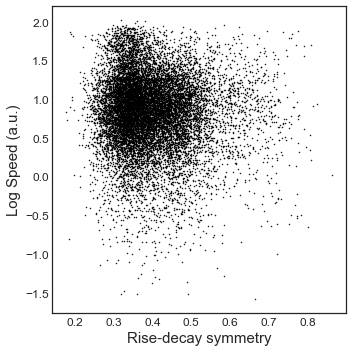

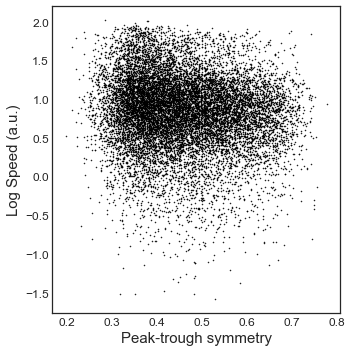

In [5]:
feat_figletter = {'amp_mv': 'H', 'periods': 'I',
                  'time_rdsym': 'J', 'time_ptsym': 'K'}

for feat, name in feat_names.items():
    plt.figure(figsize=(5,5))
    plt.plot(df_cycles[feat], np.log10(df_cycles['speed']), 'k.', ms=1)
    plt.xlabel(name, size=15)
    plt.ylabel('Log Speed (a.u.)', size=15)
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.tight_layout()
    plt.savefig('figs/8{:s}_{:s}_speed_corr.png'.format(feat_figletter[feat], feat))
    print(feat, stats.spearmanr(df_cycles[feat], np.log10(df_cycles['speed']), nan_policy='omit'))